## *price elasticity*

<img src="price_elasticity.webp" alt="picture" width="400">

*`Elasticity`*

Understanding **elasticity** is crucial in economics because it helps us grasp how sensitive people are to changes in prices or other factors.

Imagine elasticity as a measure of how much something reacts when there's a change. In this case, we're talking about how much the demand for a product or service changes when its price changes.

If something has high elasticity, it means that when its price goes up or down, people change how much they buy a lot. On the other hand, if something has low elasticity, people don't change their buying habits much, even if the price changes.

This concept is vital for **businesses** and **policymakers.** For businesses, knowing the **elasticity** of their products helps them set prices effectively. If demand is elastic, they might need to be more careful about raising prices because it could lead to a big drop in sales. Conversely, if demand is inelastic, they might have more flexibility with pricing.

In short, elasticity is like a measure of how much people care about price changes, and knowing this helps both businesses and policymakers make better decisions.

`packages`

In [1]:
# general
import psycopg2
import pandas as pd
from sqlalchemy import create_engine
import os, yaml, requests
import numpy as np

# temporal decompose
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

# distribution
from scipy.stats import skewnorm

# stas models
import statsmodels.api as sm
from statsmodels.stats import descriptivestats

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
plt.style.use('ggplot')

# sctatter plot
from pandas.plotting import scatter_matrix

# warnings
import warnings
warnings.filterwarnings('ignore')

c:\users\migue\appdata\local\programs\python\python39\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (5.2.0)/charset_normalizer (2.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


`functions`

In [2]:
def read_yaml_file(yaml_file):
    """ load yaml cofigurations """

    config = None
    try:
        with open(yaml_file, 'r') as f:
            config = yaml.safe_load(f)
    except:
        raise FileNotFoundError('Couldnt load the file')

    return config


def get_db_conn_post(creds_file):
    """ Get an authenticated psycopg db connection, given a credentials file"""
    creds = read_yaml_file(creds_file)['db']

    connection = psycopg2.connect(
        user=creds['user'],
        password=creds['pass'],
        host=creds['host'],
        port=creds['port'],
        database=creds['db']
    )

    return connection

`get data`

In [3]:
db_conn_post = get_db_conn_post("key_postgresql.yaml")

In [4]:
q = """
    select
            *
    from
            kaggle_data.price_optimization.data_gas_station;
"""

In [5]:
df_raw = pd.read_sql(sql = q, con = db_conn_post)
df_raw.head(3)

,date,day,month,year,product,hour,volume,transactions,avg_by_tkt,price,raining_days,weekday,is_weekend,holiday_name
0,2019-06-09,9,6,2019,diesel,10,47.416,2,23.708,21.09,26.1,7,1,normal day
1,2019-06-09,9,6,2019,diesel,16,100.000,1,100.000,21.09,26.1,7,1,normal day
2,2019-06-09,9,6,2019,diesel,19,9.483,1,9.483,21.09,26.1,7,1,normal day


**`adjust the dataset`**

In [6]:
# add holiday flag
df_raw['holiday_flag']=np.where(df_raw['holiday_name']!='normal day', 1, 0)

For the purpose of our analysis, we will consider that the COVID-19 pandemic began in March, and we will mark this as a significant event in our data.

In [7]:
df_raw['covid']=np.where(df_raw['date']>'2020-03-20', 1, 0)
df_raw.head(1)

,date,day,month,year,product,hour,volume,transactions,avg_by_tkt,price,raining_days,weekday,is_weekend,holiday_name,holiday_flag,covid
0,2019-06-09,9,6,2019,diesel,10,47.416,2,23.708,21.09,26.1,7,1,normal day,0,0


*create a copy form the original data*

In [8]:
df=df_raw.copy()

**`elasticity`**

Analyzing the data from the charts we've seen earlier, it seems that there might be a relationship between price changes and demand fluctuations.

Looking ahead, our main goal is to understand this relationship, especially considering the extraordinary circumstances such as the ongoing pandemic. By taking into account the timing of the pandemic and its effects on consumer behavior, we hope to uncover how demand elasticity has been influenced.

*price vs sales*

Exploring the dynamics of product elasticity amidst the backdrop of a pandemic-induced lockdown reveals intriguing insights. Observing the chart below, it becomes evident that the product exhibits characteristics of inelasticity. Despite a higher price point, sales remain robust, indicating a lesser degree of responsiveness to price changes. However, it's crucial to note that this trend is intricately tied to the unique circumstances of the lockdown imposed due to the pandemic. Let's delve deeper into the implications of this phenomenon.

In [9]:
cols = ['date', 'hour', 'volume', 'price', 'raining_days', 'weekday', 'is_weekend', 'holiday_flag', 'covid']
condition=df['product']=='regular'
data=df[cols][condition].\
            groupby(by=['date', 'weekday', 'is_weekend', 'hour', 'raining_days','holiday_flag', 'covid'], as_index=False).\
            agg({'volume':'sum', 'price':'mean'}).\
            drop(columns='date', inplace=False)

data_raw=data.copy()
print(data.shape)
data.head(1)

(8379, 8)


,weekday,is_weekend,hour,raining_days,holiday_flag,covid,volume,price
0,7,1,6,26.1,0,0,84.356,19.59


The subsequent phase involves delving deeper into the correlation between pricing and sales to ascertain whether a linear relationship exists.

In [10]:
data_group=data[['price', 'volume']].groupby(by='price', as_index=False).sum()
data_group.head(1)

,price,volume
0,12.89,30964.281


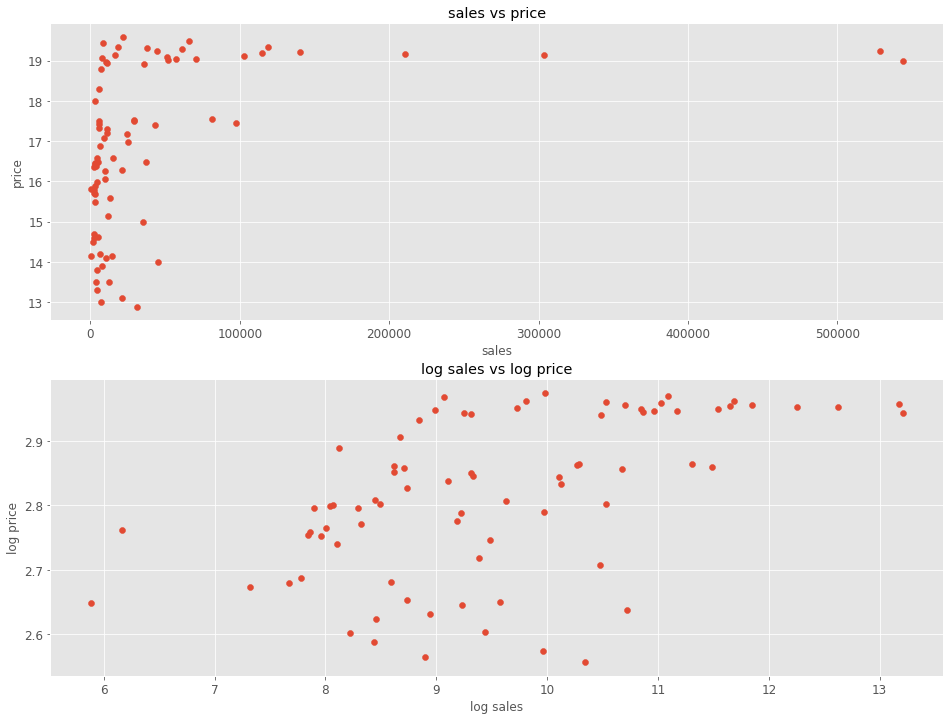

In [11]:
plt.figure(figsize=(16, 12))

plt.subplot(211)
plt.scatter(x=data_group['volume'], y=data_group['price'])
plt.title('sales vs price')
plt.xlabel('sales')
plt.ylabel('price')

plt.subplot(212)
plt.scatter(x=np.log(data_group['volume']), y=np.log(data_group['price']))
plt.title('log sales vs log price')
plt.xlabel('log sales')
plt.ylabel('log price')
plt.show()

In the charts above, we can discern the connection between price and sales, as well as these variables when logged. However, it's evident that a linear relationship between them is not apparent. Therefore, our subsequent move is to ascertain the elasticity to understand:

The effect of price on sales (elasticity).

In [12]:
import statsmodels.api as ms

data['log_volume']=np.log(data['volume'])
data['log_price']=np.log(data['price'])

X=data['log_price']
y=data['log_volume']
X=sm.add_constant(X)
sm_model01=sm.OLS(y, X).fit()

In [13]:
print('elasticity: ', sm_model01.params['log_price'])
print('intercept: ', sm_model01.params['const'])

elasticity:  3.49761691567335
intercept:  -4.415641022583361


In [14]:
sm_model01.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_volume   R-squared:                       0.125
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     1198.
Date:                Tue, 02 Apr 2024   Prob (F-statistic):          1.56e-245
Time:                        13:49:20   Log-Likelihood:                -11689.
No. Observations:                8379   AIC:                         2.338e+04
Df Residuals:                    8377   BIC:                         2.340e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.4156      0.292    -15.141      0.000      -4.987      -3.844
log_price      3.4976      0.101     34.616      0.000       3.300       3.696
==============================================================================
Omnibus:                     3930.551   Durbin-Watson:                   0.735
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            26412.839
Skew:                          -2.156   Prob(JB):                         0.00
Kurtosis:                      10.554   Cond. No.                         88.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In the table provided above, we note that the model's elasticity stands at **3.49.** It's noteworthy that the elasticity isn't negative, suggesting that there are periods when both price and sales trend upwards concurrently. To gain deeper insights, it's imperative to introduce additional factors such as the time of day or the frequency of rainy days.

It's crucial to emphasize that we're logging the price to grasp the percentage change between the price and the sales.

In [15]:
data=data[data['covid']==0]

In [16]:
data['log_volume']=np.log(data['volume'])
data['log_price']=np.log(data['price'])

X=data['log_price']
y=data['log_volume']
X=sm.add_constant(X)
sm_model02=sm.OLS(y, X).fit()

In [17]:
sm_model02.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             log_volume   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.948
Date:                Tue, 02 Apr 2024   Prob (F-statistic):             0.0262
Time:                        13:49:20   Log-Likelihood:                -6901.1
No. Observations:                5281   AIC:                         1.381e+04
Df Residuals:                    5279   BIC:                         1.382e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5109      1.572      1.597      0.110      -0.571       5.593
log_price      1.1856      0.533      2.224      0.026       0.141       2.230
==============================================================================
Omnibus:                     3530.900   Durbin-Watson:                   0.899
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            53652.538
Skew:                          -3.026   Prob(JB):                         0.00
Kurtosis:                      17.395   Cond. No.                         420.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As observed, despite the decrease in the price coefficient, there is a consistent positive contribution that remains statistically significant.

In the OLS models examined, the **elasticity**—how one variable responds to changes in another—shifts when COVID-19 data is included, resulting in slightly smaller elasticities. However, despite this decrease, the first OLS model demonstrates a stronger ability to explain volume based on **price dynamics,** as indicated by its higher R<sup>2</sup> value. 

Additionally, the integration of COVID-19 data leads to a reduction in kurtosis, reflecting a smoother distribution of data points. These findings suggest that while the pandemic influences the relationships between variables, certain models retain their explanatory power and exhibit less volatility.

In [21]:
data=data_raw

*real data vs OLS predictions*

Considering the following equation that illustrates the anticipated demand curve,
$$ Y = \alpha \cdot P^b $$
where
$$\alpha=e^a$$
and, where *a* represents the intercept of the Ordinary Least Squares (OLS) model and *b* signifies the elasticity, we observe the following relationship:

In [27]:
a=sm_model01.params['const']
b=sm_model01.params['log_price']

In [34]:
# demand function

def demand(a, b, P):
    alfa=np.exp(a)
    return alfa*(P**b)

In [36]:
data['expect_Y']=data['price'].apply(lambda x: demand(a, b, x))

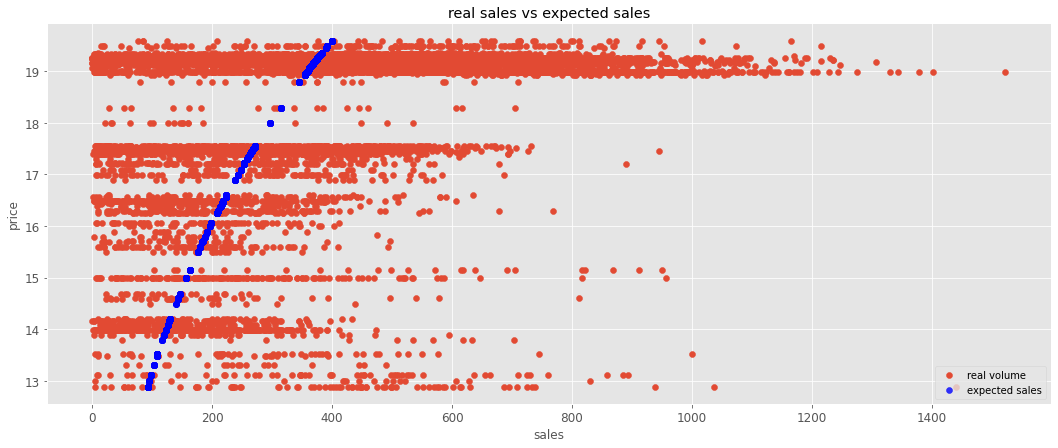

In [38]:
plt.figure(figsize=(18, 7))

plt.scatter(x=data['volume'], y=data['price'], alpha=1, label='real volume')
plt.scatter(x=data['expect_Y'], y=data['price'], alpha=0.8, label='expected sales', color='b')

plt.title('real sales vs expected sales')
plt.xlabel('sales')
plt.ylabel('price')
plt.legend(loc='lower right')

plt.show()

As depicted in the chart above, our model's predictive accuracy regarding volume is not particularly high. However, it does provide insight into volume trends, particularly when considering **price fluctuations.** It's important to acknowledge that our output is influenced by various factors such as time of day, day of the week, and weather conditions, not solely reliant on price. Moreover, in accordance with **elasticity,** an increase in price correlates with an increase in volume. However, it's evident that the volume is not highly sensitive to price changes.

**`price power-up zone`**